In [1]:
import zipfile
import os
import numpy as np
import pathlib
import pandas as pd
from math import ceil
import tensorflow as tf
import numpy as np
import IPython.display as display
import keras
from keras import backend as K
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from keras_preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10


print(tf.__version__)

root_path = './'

models_path = os.path.join(root_path, 'saved_models_new')
if not os.path.exists(models_path):
    os.mkdir(models_path)


tgt_pth = os.path.join(root_path, 'visualize_dcgan-v35')

if not os.path.exists(tgt_pth):
    os.mkdir(tgt_pth)



BATCH_SIZE = 128
img_rows, img_cols, img_depth = (32, 32, 3)
num_classes = 10


# The data, split between train and test sets:
(x_train, y_train), (_, _) = cifar10.load_data()


# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)


x_train = x_train.astype('float32')
x_train = x_train / 127.5 - 1

def rescaleFn(img):
    return img / 127.5 - 1


datagen=ImageDataGenerator()


# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

train_generator = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

Using TensorFlow backend.


1.13.1


In [2]:
img_shape = (32, 32, 3)
img_len = np.prod(img_shape)
latent_dim = img_len
noise_len = 100
input_dim = noise_len + num_classes
ngf = 32  # generator
ndf = 32  # discriminator
kernel_size = (5, 5)


def build_discriminator():
    model = keras.Sequential([
        # conv block 1, (5, 5)@32
        keras.layers.Conv2D(
            filters=ndf,
            kernel_size=kernel_size,
            strides=2,
            input_shape=img_shape,
            use_bias=False,
            kernel_initializer=keras.initializers.glorot_normal(),
            padding='same'
        ),
        keras.layers.LeakyReLU(alpha=0.2),
        
        # conv block 2, (5, 5)@64
        keras.layers.Conv2D(
            filters=ndf * 2,
            kernel_size=kernel_size,
            strides=2,
            use_bias=False,
            kernel_initializer=keras.initializers.glorot_normal(),
            padding='same'
        ),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=0.2),
        
        # conv block 3, (5, 5)@128
        keras.layers.Conv2D(
            filters=ndf * 4,
            kernel_size=kernel_size,
            strides=2,
            use_bias=False,
            kernel_initializer=keras.initializers.glorot_normal(),
            padding='same'
        ),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=0.2),
        
        # conv block 4, (5, 5)@256
        keras.layers.Conv2D(
            filters=ndf * 8,
            kernel_size=kernel_size,
            strides=2,
            use_bias=False,
            kernel_initializer=keras.initializers.glorot_normal(),
            padding='same'
        ),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=0.2),
    ])
    
    valid = keras.Sequential([
        # conv block 4
        keras.layers.Conv2D(
            filters=1,
            kernel_size=(1, 1),
            strides=2,
            use_bias=False,
            kernel_initializer=keras.initializers.glorot_normal(),
            padding='same',
            input_shape=(1*1*ndf*8)
        ),
        
        #output
        keras.layers.Activation('sigmoid'),
        
        #flatten
        keras.layers.Flatten()
    ])
    
    clf = keras.Sequential([
        # conv block 4
        keras.layers.Conv2D(
            filters=num_classes,
            kernel_size=(1, 1),
            strides=2,
            use_bias=False,
            kernel_initializer=keras.initializers.glorot_normal(),
            padding='same',
            input_shape=(1*1*ndf*8)
        ),
        
        #output
        keras.layers.Activation('softmax'),
        
        #flatten
        keras.layers.Flatten()
    ])
    
    # image
    x = keras.layers.Input(shape=img_shape)
    
    # learned representation
    features = model(x)
    
    # fake or real
    out_1 = valid(features)
    
    # label?
    out_2 = clf(features)
    
    return keras.models.Model(x, [out_1, out_2])
    


def build_generator():
    
    model = keras.Sequential([
        # 100 noise to 1024
        keras.layers.Dense(2*2*256, input_shape=(input_dim,)),
        
        # reshape 1d to 3d
        keras.layers.Reshape((2, 2, 256)),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=0.2),
        
        # transpose conv block 1, (5, 5)@128
        keras.layers.Conv2DTranspose(
            filters=ngf * 4,
            kernel_size=kernel_size,
            strides=2,
            use_bias=False,
            kernel_initializer=keras.initializers.glorot_normal(),
            padding='same'
        ),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=0.2),
        
        # transpose conv block 2, (5, 5)@64
        keras.layers.Conv2DTranspose(
            filters=ngf * 2,
            kernel_size=(3, 3),
            strides=2,
            use_bias=False,
            kernel_initializer=keras.initializers.glorot_normal(),
            padding='same'
        ),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=0.2),
        
        # transpose conv block 3, (5, 5)@32
        keras.layers.Conv2DTranspose(
            filters=ngf,
            kernel_size=(3, 3),
            strides=2,
            use_bias=False,
            kernel_initializer=keras.initializers.glorot_normal(),
            padding='same'
        ),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=0.2),
        
        # transpose conv block 6
        keras.layers.Conv2DTranspose(
            filters=3,
            kernel_size=kernel_size,
            strides=2,
            use_bias=False,
            kernel_initializer=keras.initializers.glorot_normal(),
            padding='same'
        ),
        
        # output
        keras.layers.Activation('tanh')
    ])
    
    # condition
    c = keras.layers.Input(shape=(num_classes,))
    
    # noise
    z = keras.layers.Input(shape=(noise_len,))

    # concatenation
    inputs = keras.layers.concatenate([c, z])
    
    # flat dense output
    x = model(inputs)
    
    return keras.models.Model([c, z], x)


discriminator = build_discriminator()
generator = build_generator()

generator.summary()
discriminator.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              103424    
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 256)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 2, 2, 256)         1024      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 128)         819200    
_________________________________________________________________
batch_normalization_5 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
leak

In [3]:
GLR = 0.0002  # generator
DLR = 0.0002  # discriminator
LR = 0.00002


optim = keras.optimizers.Adam(LR, beta_1=0.5)


discriminator.compile(
    optimizer=optim,
    loss=[keras.losses.binary_crossentropy, keras.losses.categorical_crossentropy],
    metrics=['accuracy']
)

# noise
z = keras.layers.Input(shape=(noise_len,))

# freeze discriminator
discriminator.trainable = False

# output
x = generator(z)
out_1, out_2 = discriminator(x)

# GAN
gan = keras.models.Model(inputs=z, outputs=[out_1, out_2])

gan.compile(
    optimizer=optim,
    loss=[keras.losses.binary_crossentropy, keras.losses.categorical_crossentropy],
    metrics=['accuracy'])

In [4]:
def visualizeGAN(e, z_real, z_fake):

    fig, axes = plt.subplots(4, 5, figsize=(20, 18))

    r_real = 0
    r_fake = 0
    for row, axe in enumerate(axes):
        for col, cell in enumerate(axe):
            if row % 2 == 0:
                cell.imshow(
                    0.5 * z_real[r_real * 5 + col] + 0.5
                )
            else:
                cell.imshow(
                    0.5 * z_fake[r_fake * 5 + col] + 0.5
                )

            cell.axis("off")

        if row % 2 == 0:
            r_real += 1
        else:
            r_fake += 1

    plt.axis("off")
    plt.tight_layout()

    fig.savefig(os.path.join(tgt_pth, '{}.jpg'.format(str(e).zfill(3))))
    
    plt.close()

In [5]:
EPOCHS = 250001
STEPS = 1


train_loss_g = []
train_loss_d = []

train_acc_g = []
train_acc_d = []


# to be visualized
vis_noise = np.random.normal(size=(10, noise_len,))

# fake and real label ( Label Smoothing & Label Flipping )
y_fake = np.zeros(shape=(BATCH_SIZE,))
y_real = np.ones(shape=(BATCH_SIZE,))

# epochs
for e in range(EPOCHS):

    #batches
    loss = []
    acc = []

    for p in range(STEPS * 4):
        
        x_real, c = next(train_generator)
        z = np.random.normal(loc=0, scale=1, size=(BATCH_SIZE, noise_len))
        x_fake = generator.predict([z c])
        
        if x_real.shape[0] < BATCH_SIZE:
            x_real = next(train_generator)

        # add noise
#         x_real = x_real + np.random.normal(loc=0, scale=0.01, size=x_real.shape)
#         x_fake = x_fake + np.random.normal(loc=0, scale=0.01, size=x_fake.shape)
#         y_real = np.random.normal(loc=0.95, scale=0.05, size=(BATCH_SIZE,))
    
        # train
        loss_1, _, _, _, acc_1 = discriminator.train_on_batch(x_fake, y_fake)
        loss_2, _, _, _, acc_2 = discriminator.train_on_batch(x_real, y_real)

        batch_loss = 0.5 * (loss_1 + loss_2)
        batch_acc = 0.5 * (acc_1 + acc_2)

        loss.append(batch_loss)
        acc.append(batch_acc)

    train_loss_d.append(np.mean(np.array(loss)))
    train_acc_d.append(np.mean(np.array(acc)))

    #batches
    loss = []
    acc = []

    for p in range(STEPS):
        _, c = next(train_generator)
        z = np.random.normal(loc=0, scale=1, size=(BATCH_SIZE, noise_len))
#         y_real = np.random.normal(loc=0.95, scale=0.05, size=(BATCH_SIZE,))
        
        # train
        loss_1, _, _, _, acc_1 = gan.train_on_batch([z c], y_real)
        
        loss.append(loss_1)
        acc.append(acc_1)

    train_loss_g.append(np.mean(np.array(loss)))
    train_acc_g.append(np.mean(np.array(acc)))


    print("E: {}, [D ACC: %{:.2f}], [D LOSS: {:.2f}], [G ACC: %{:.2f}], [G LOSS: {:.2f}]".format(
          e,
          train_acc_d[-1] * 100,
          train_loss_d[-1] * 100,
          train_acc_g[-1] * 100,
          train_loss_g[-1] * 100
      ))

    if e % 200 == 0:
        ## visualize results
        viz_fake = generator.predict(vis_noise)
        x_real = next(train_generator)
        visualizeGAN(e, x_real, viz_fake)
        
## save model
pth = os.path.join(models_path, 'gan.h5')
gan.save(pth)

pth = os.path.join(models_path, 'generator-{}-{}-{}.h5'.format(e, train_loss_g[-1], train_acc_g[-1]))
generator.save(pth)

pth = os.path.join(models_path, 'discriminator.h5')
discriminator.save(pth)

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


E: 0, [D ACC: %69.04], [D LOSS: 60.42], [G ACC: %22.66], [G LOSS: 124.83]
E: 1, [D ACC: %87.60], [D LOSS: 36.62], [G ACC: %3.12], [G LOSS: 198.00]
E: 2, [D ACC: %96.09], [D LOSS: 24.27], [G ACC: %0.78], [G LOSS: 214.84]
E: 3, [D ACC: %97.85], [D LOSS: 18.04], [G ACC: %0.00], [G LOSS: 255.81]
E: 4, [D ACC: %98.44], [D LOSS: 15.23], [G ACC: %0.00], [G LOSS: 269.39]
E: 5, [D ACC: %99.12], [D LOSS: 13.24], [G ACC: %0.00], [G LOSS: 281.12]
E: 6, [D ACC: %99.12], [D LOSS: 12.48], [G ACC: %0.00], [G LOSS: 282.26]
E: 7, [D ACC: %99.71], [D LOSS: 10.14], [G ACC: %0.00], [G LOSS: 307.34]
E: 8, [D ACC: %99.51], [D LOSS: 9.35], [G ACC: %0.00], [G LOSS: 324.02]
E: 9, [D ACC: %99.90], [D LOSS: 7.83], [G ACC: %0.00], [G LOSS: 342.42]
E: 10, [D ACC: %99.80], [D LOSS: 7.09], [G ACC: %0.00], [G LOSS: 343.84]
E: 11, [D ACC: %99.80], [D LOSS: 6.82], [G ACC: %0.00], [G LOSS: 359.08]
E: 12, [D ACC: %99.90], [D LOSS: 6.30], [G ACC: %0.00], [G LOSS: 365.44]
E: 13, [D ACC: %99.90], [D LOSS: 5.75], [G ACC: %0.0

E: 112, [D ACC: %99.90], [D LOSS: 1.06], [G ACC: %0.00], [G LOSS: 611.24]
E: 113, [D ACC: %100.00], [D LOSS: 0.75], [G ACC: %0.00], [G LOSS: 611.22]
E: 114, [D ACC: %100.00], [D LOSS: 0.79], [G ACC: %0.00], [G LOSS: 616.80]
E: 115, [D ACC: %100.00], [D LOSS: 0.76], [G ACC: %0.00], [G LOSS: 611.99]
E: 116, [D ACC: %100.00], [D LOSS: 0.82], [G ACC: %0.00], [G LOSS: 624.99]
E: 117, [D ACC: %100.00], [D LOSS: 0.75], [G ACC: %0.00], [G LOSS: 639.90]
E: 118, [D ACC: %100.00], [D LOSS: 0.77], [G ACC: %0.00], [G LOSS: 636.13]
E: 119, [D ACC: %100.00], [D LOSS: 0.78], [G ACC: %0.00], [G LOSS: 628.16]
E: 120, [D ACC: %100.00], [D LOSS: 0.68], [G ACC: %0.00], [G LOSS: 640.60]
E: 121, [D ACC: %100.00], [D LOSS: 0.71], [G ACC: %0.00], [G LOSS: 660.63]
E: 122, [D ACC: %100.00], [D LOSS: 0.73], [G ACC: %0.00], [G LOSS: 642.20]
E: 123, [D ACC: %100.00], [D LOSS: 0.73], [G ACC: %0.00], [G LOSS: 649.23]
E: 124, [D ACC: %100.00], [D LOSS: 0.56], [G ACC: %0.00], [G LOSS: 655.01]
E: 125, [D ACC: %100.00], 

E: 222, [D ACC: %100.00], [D LOSS: 0.20], [G ACC: %0.00], [G LOSS: 602.04]
E: 223, [D ACC: %100.00], [D LOSS: 0.23], [G ACC: %0.00], [G LOSS: 595.95]
E: 224, [D ACC: %100.00], [D LOSS: 0.17], [G ACC: %0.00], [G LOSS: 601.60]
E: 225, [D ACC: %100.00], [D LOSS: 0.16], [G ACC: %0.00], [G LOSS: 600.65]
E: 226, [D ACC: %100.00], [D LOSS: 0.17], [G ACC: %0.00], [G LOSS: 612.95]
E: 227, [D ACC: %100.00], [D LOSS: 0.22], [G ACC: %0.00], [G LOSS: 566.27]
E: 228, [D ACC: %100.00], [D LOSS: 0.20], [G ACC: %0.00], [G LOSS: 588.08]
E: 229, [D ACC: %100.00], [D LOSS: 0.15], [G ACC: %0.00], [G LOSS: 597.79]
E: 230, [D ACC: %100.00], [D LOSS: 0.20], [G ACC: %0.00], [G LOSS: 610.78]
E: 231, [D ACC: %100.00], [D LOSS: 0.15], [G ACC: %0.00], [G LOSS: 589.01]
E: 232, [D ACC: %100.00], [D LOSS: 0.24], [G ACC: %0.00], [G LOSS: 598.76]
E: 233, [D ACC: %100.00], [D LOSS: 0.17], [G ACC: %0.00], [G LOSS: 616.39]
E: 234, [D ACC: %100.00], [D LOSS: 0.15], [G ACC: %0.00], [G LOSS: 605.71]
E: 235, [D ACC: %100.00],

E: 332, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %17.97], [G LOSS: 127.45]
E: 333, [D ACC: %100.00], [D LOSS: 0.07], [G ACC: %14.06], [G LOSS: 139.11]
E: 334, [D ACC: %100.00], [D LOSS: 0.10], [G ACC: %32.03], [G LOSS: 113.34]
E: 335, [D ACC: %100.00], [D LOSS: 0.08], [G ACC: %14.06], [G LOSS: 143.88]
E: 336, [D ACC: %100.00], [D LOSS: 0.08], [G ACC: %9.38], [G LOSS: 147.86]
E: 337, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %6.25], [G LOSS: 166.32]
E: 338, [D ACC: %100.00], [D LOSS: 0.08], [G ACC: %14.06], [G LOSS: 135.70]
E: 339, [D ACC: %100.00], [D LOSS: 0.05], [G ACC: %16.41], [G LOSS: 136.64]
E: 340, [D ACC: %100.00], [D LOSS: 0.05], [G ACC: %11.72], [G LOSS: 140.75]
E: 341, [D ACC: %100.00], [D LOSS: 0.18], [G ACC: %1.56], [G LOSS: 257.46]
E: 342, [D ACC: %100.00], [D LOSS: 0.04], [G ACC: %5.47], [G LOSS: 180.06]
E: 343, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %26.56], [G LOSS: 109.39]
E: 344, [D ACC: %100.00], [D LOSS: 0.09], [G ACC: %16.41], [G LOSS: 131.85]
E: 345, [D ACC: 

E: 441, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %0.00], [G LOSS: 373.59]
E: 442, [D ACC: %100.00], [D LOSS: 0.10], [G ACC: %0.00], [G LOSS: 333.49]
E: 443, [D ACC: %100.00], [D LOSS: 0.10], [G ACC: %0.00], [G LOSS: 307.27]
E: 444, [D ACC: %100.00], [D LOSS: 0.07], [G ACC: %0.00], [G LOSS: 414.14]
E: 445, [D ACC: %100.00], [D LOSS: 0.08], [G ACC: %0.00], [G LOSS: 362.63]
E: 446, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %0.00], [G LOSS: 437.83]
E: 447, [D ACC: %100.00], [D LOSS: 0.04], [G ACC: %0.00], [G LOSS: 399.71]
E: 448, [D ACC: %100.00], [D LOSS: 0.08], [G ACC: %0.00], [G LOSS: 393.53]
E: 449, [D ACC: %100.00], [D LOSS: 0.07], [G ACC: %0.00], [G LOSS: 426.35]
E: 450, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %0.00], [G LOSS: 346.31]
E: 451, [D ACC: %100.00], [D LOSS: 0.10], [G ACC: %0.00], [G LOSS: 361.03]
E: 452, [D ACC: %100.00], [D LOSS: 0.11], [G ACC: %0.00], [G LOSS: 384.48]
E: 453, [D ACC: %100.00], [D LOSS: 0.10], [G ACC: %0.78], [G LOSS: 300.22]
E: 454, [D ACC: %100.00],

E: 551, [D ACC: %100.00], [D LOSS: 0.07], [G ACC: %0.00], [G LOSS: 404.17]
E: 552, [D ACC: %100.00], [D LOSS: 0.16], [G ACC: %0.78], [G LOSS: 372.24]
E: 553, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %0.78], [G LOSS: 386.34]
E: 554, [D ACC: %100.00], [D LOSS: 0.30], [G ACC: %0.00], [G LOSS: 507.46]
E: 555, [D ACC: %100.00], [D LOSS: 0.08], [G ACC: %0.00], [G LOSS: 391.65]
E: 556, [D ACC: %100.00], [D LOSS: 0.05], [G ACC: %0.00], [G LOSS: 477.82]
E: 557, [D ACC: %100.00], [D LOSS: 0.07], [G ACC: %0.00], [G LOSS: 380.66]
E: 558, [D ACC: %100.00], [D LOSS: 0.13], [G ACC: %0.78], [G LOSS: 377.01]
E: 559, [D ACC: %100.00], [D LOSS: 0.11], [G ACC: %0.00], [G LOSS: 432.95]
E: 560, [D ACC: %100.00], [D LOSS: 0.08], [G ACC: %0.00], [G LOSS: 531.22]
E: 561, [D ACC: %100.00], [D LOSS: 0.09], [G ACC: %12.50], [G LOSS: 236.71]
E: 562, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %0.78], [G LOSS: 419.61]
E: 563, [D ACC: %100.00], [D LOSS: 0.11], [G ACC: %3.12], [G LOSS: 363.20]
E: 564, [D ACC: %90.53],

E: 661, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %14.06], [G LOSS: 175.60]
E: 662, [D ACC: %100.00], [D LOSS: 0.28], [G ACC: %1.56], [G LOSS: 228.63]
E: 663, [D ACC: %100.00], [D LOSS: 0.19], [G ACC: %14.06], [G LOSS: 181.06]
E: 664, [D ACC: %100.00], [D LOSS: 0.18], [G ACC: %11.72], [G LOSS: 199.81]
E: 665, [D ACC: %100.00], [D LOSS: 0.34], [G ACC: %0.00], [G LOSS: 311.49]
E: 666, [D ACC: %100.00], [D LOSS: 0.16], [G ACC: %7.03], [G LOSS: 208.99]
E: 667, [D ACC: %100.00], [D LOSS: 0.22], [G ACC: %41.41], [G LOSS: 104.13]
E: 668, [D ACC: %100.00], [D LOSS: 0.20], [G ACC: %3.12], [G LOSS: 210.70]
E: 669, [D ACC: %100.00], [D LOSS: 0.19], [G ACC: %14.84], [G LOSS: 149.22]
E: 670, [D ACC: %100.00], [D LOSS: 0.18], [G ACC: %20.31], [G LOSS: 142.06]
E: 671, [D ACC: %100.00], [D LOSS: 0.22], [G ACC: %15.62], [G LOSS: 143.43]
E: 672, [D ACC: %100.00], [D LOSS: 0.16], [G ACC: %28.91], [G LOSS: 125.86]
E: 673, [D ACC: %100.00], [D LOSS: 0.37], [G ACC: %0.00], [G LOSS: 373.05]
E: 674, [D ACC: %

E: 770, [D ACC: %100.00], [D LOSS: 0.21], [G ACC: %0.00], [G LOSS: 458.34]
E: 771, [D ACC: %99.90], [D LOSS: 0.28], [G ACC: %0.00], [G LOSS: 470.85]
E: 772, [D ACC: %100.00], [D LOSS: 0.26], [G ACC: %0.00], [G LOSS: 556.76]
E: 773, [D ACC: %100.00], [D LOSS: 0.15], [G ACC: %0.00], [G LOSS: 633.36]
E: 774, [D ACC: %100.00], [D LOSS: 0.16], [G ACC: %0.00], [G LOSS: 519.73]
E: 775, [D ACC: %99.90], [D LOSS: 0.35], [G ACC: %0.00], [G LOSS: 531.40]
E: 776, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %0.00], [G LOSS: 518.90]
E: 777, [D ACC: %100.00], [D LOSS: 0.10], [G ACC: %0.00], [G LOSS: 548.21]
E: 778, [D ACC: %100.00], [D LOSS: 0.16], [G ACC: %0.00], [G LOSS: 529.68]
E: 779, [D ACC: %100.00], [D LOSS: 0.18], [G ACC: %0.00], [G LOSS: 549.71]
E: 780, [D ACC: %100.00], [D LOSS: 0.23], [G ACC: %0.00], [G LOSS: 432.78]
E: 781, [D ACC: %100.00], [D LOSS: 0.28], [G ACC: %0.00], [G LOSS: 566.29]
E: 782, [D ACC: %100.00], [D LOSS: 0.14], [G ACC: %0.00], [G LOSS: 500.34]
E: 783, [D ACC: %100.00], [

E: 880, [D ACC: %100.00], [D LOSS: 0.15], [G ACC: %0.00], [G LOSS: 766.60]
E: 881, [D ACC: %100.00], [D LOSS: 0.16], [G ACC: %0.00], [G LOSS: 786.55]
E: 882, [D ACC: %100.00], [D LOSS: 0.16], [G ACC: %0.00], [G LOSS: 691.60]
E: 883, [D ACC: %100.00], [D LOSS: 0.14], [G ACC: %0.00], [G LOSS: 701.63]
E: 884, [D ACC: %99.71], [D LOSS: 0.81], [G ACC: %0.00], [G LOSS: 678.47]
E: 885, [D ACC: %100.00], [D LOSS: 0.21], [G ACC: %0.00], [G LOSS: 761.99]
E: 886, [D ACC: %100.00], [D LOSS: 0.14], [G ACC: %0.00], [G LOSS: 728.44]
E: 887, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %0.00], [G LOSS: 762.67]
E: 888, [D ACC: %100.00], [D LOSS: 0.21], [G ACC: %0.00], [G LOSS: 773.71]
E: 889, [D ACC: %100.00], [D LOSS: 0.11], [G ACC: %0.00], [G LOSS: 815.27]
E: 890, [D ACC: %100.00], [D LOSS: 0.23], [G ACC: %0.00], [G LOSS: 639.21]
E: 891, [D ACC: %100.00], [D LOSS: 0.17], [G ACC: %0.00], [G LOSS: 715.16]
E: 892, [D ACC: %100.00], [D LOSS: 0.24], [G ACC: %0.00], [G LOSS: 741.40]
E: 893, [D ACC: %100.00], 

E: 990, [D ACC: %100.00], [D LOSS: 0.05], [G ACC: %0.00], [G LOSS: 606.85]
E: 991, [D ACC: %100.00], [D LOSS: 0.08], [G ACC: %0.00], [G LOSS: 619.74]
E: 992, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %0.00], [G LOSS: 574.07]
E: 993, [D ACC: %100.00], [D LOSS: 0.07], [G ACC: %0.00], [G LOSS: 560.21]
E: 994, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %0.00], [G LOSS: 688.60]
E: 995, [D ACC: %100.00], [D LOSS: 0.22], [G ACC: %0.00], [G LOSS: 574.03]
E: 996, [D ACC: %99.90], [D LOSS: 0.61], [G ACC: %0.00], [G LOSS: 427.66]
E: 997, [D ACC: %100.00], [D LOSS: 0.11], [G ACC: %0.00], [G LOSS: 550.65]
E: 998, [D ACC: %100.00], [D LOSS: 0.07], [G ACC: %0.00], [G LOSS: 601.52]
E: 999, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %0.00], [G LOSS: 593.99]
E: 1000, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %0.78], [G LOSS: 518.62]
E: 1001, [D ACC: %100.00], [D LOSS: 0.08], [G ACC: %0.00], [G LOSS: 511.38]
E: 1002, [D ACC: %100.00], [D LOSS: 0.10], [G ACC: %0.00], [G LOSS: 552.22]
E: 1003, [D ACC: %100.0

E: 1099, [D ACC: %100.00], [D LOSS: 0.14], [G ACC: %3.91], [G LOSS: 321.34]
E: 1100, [D ACC: %100.00], [D LOSS: 0.20], [G ACC: %2.34], [G LOSS: 329.74]
E: 1101, [D ACC: %100.00], [D LOSS: 0.10], [G ACC: %13.28], [G LOSS: 224.28]
E: 1102, [D ACC: %100.00], [D LOSS: 0.16], [G ACC: %6.25], [G LOSS: 272.77]
E: 1103, [D ACC: %100.00], [D LOSS: 0.18], [G ACC: %1.56], [G LOSS: 364.79]
E: 1104, [D ACC: %100.00], [D LOSS: 0.18], [G ACC: %3.12], [G LOSS: 375.56]
E: 1105, [D ACC: %99.90], [D LOSS: 0.32], [G ACC: %17.97], [G LOSS: 229.15]
E: 1106, [D ACC: %100.00], [D LOSS: 0.15], [G ACC: %1.56], [G LOSS: 334.89]
E: 1107, [D ACC: %100.00], [D LOSS: 0.20], [G ACC: %17.97], [G LOSS: 182.07]
E: 1108, [D ACC: %100.00], [D LOSS: 0.17], [G ACC: %13.28], [G LOSS: 218.46]
E: 1109, [D ACC: %99.90], [D LOSS: 0.62], [G ACC: %0.00], [G LOSS: 500.50]
E: 1110, [D ACC: %99.80], [D LOSS: 1.01], [G ACC: %1.56], [G LOSS: 363.03]
E: 1111, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %0.78], [G LOSS: 344.41]
E: 1112, [D

E: 1207, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %46.88], [G LOSS: 103.11]
E: 1208, [D ACC: %100.00], [D LOSS: 0.08], [G ACC: %52.34], [G LOSS: 102.05]
E: 1209, [D ACC: %100.00], [D LOSS: 0.15], [G ACC: %67.97], [G LOSS: 71.60]
E: 1210, [D ACC: %100.00], [D LOSS: 0.10], [G ACC: %55.47], [G LOSS: 89.05]
E: 1211, [D ACC: %100.00], [D LOSS: 0.05], [G ACC: %48.44], [G LOSS: 113.45]
E: 1212, [D ACC: %100.00], [D LOSS: 0.03], [G ACC: %43.75], [G LOSS: 122.10]
E: 1213, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %55.47], [G LOSS: 82.21]
E: 1214, [D ACC: %100.00], [D LOSS: 0.10], [G ACC: %64.06], [G LOSS: 82.65]
E: 1215, [D ACC: %100.00], [D LOSS: 0.07], [G ACC: %57.03], [G LOSS: 89.49]
E: 1216, [D ACC: %100.00], [D LOSS: 0.08], [G ACC: %81.25], [G LOSS: 46.81]
E: 1217, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %72.66], [G LOSS: 56.08]
E: 1218, [D ACC: %100.00], [D LOSS: 0.08], [G ACC: %57.81], [G LOSS: 87.67]
E: 1219, [D ACC: %100.00], [D LOSS: 0.05], [G ACC: %57.03], [G LOSS: 84.22]
E: 1220,

E: 1315, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %0.00], [G LOSS: 554.86]
E: 1316, [D ACC: %100.00], [D LOSS: 0.18], [G ACC: %0.00], [G LOSS: 556.07]
E: 1317, [D ACC: %100.00], [D LOSS: 0.25], [G ACC: %0.00], [G LOSS: 799.50]
E: 1318, [D ACC: %100.00], [D LOSS: 0.16], [G ACC: %0.00], [G LOSS: 577.04]
E: 1319, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %0.00], [G LOSS: 548.57]
E: 1320, [D ACC: %100.00], [D LOSS: 0.08], [G ACC: %0.00], [G LOSS: 593.54]
E: 1321, [D ACC: %100.00], [D LOSS: 0.05], [G ACC: %0.00], [G LOSS: 609.66]
E: 1322, [D ACC: %100.00], [D LOSS: 0.07], [G ACC: %0.00], [G LOSS: 542.86]
E: 1323, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %0.00], [G LOSS: 640.03]
E: 1324, [D ACC: %100.00], [D LOSS: 0.36], [G ACC: %0.00], [G LOSS: 665.09]
E: 1325, [D ACC: %100.00], [D LOSS: 0.10], [G ACC: %0.00], [G LOSS: 587.22]
E: 1326, [D ACC: %100.00], [D LOSS: 0.13], [G ACC: %0.00], [G LOSS: 572.39]
E: 1327, [D ACC: %100.00], [D LOSS: 0.13], [G ACC: %0.00], [G LOSS: 655.21]
E: 1328, [D 

E: 1423, [D ACC: %99.71], [D LOSS: 0.54], [G ACC: %0.00], [G LOSS: 682.91]
E: 1424, [D ACC: %100.00], [D LOSS: 0.18], [G ACC: %0.00], [G LOSS: 714.28]
E: 1425, [D ACC: %99.90], [D LOSS: 0.30], [G ACC: %0.00], [G LOSS: 643.33]
E: 1426, [D ACC: %100.00], [D LOSS: 0.16], [G ACC: %0.00], [G LOSS: 633.32]
E: 1427, [D ACC: %100.00], [D LOSS: 0.04], [G ACC: %0.00], [G LOSS: 591.53]
E: 1428, [D ACC: %100.00], [D LOSS: 0.17], [G ACC: %1.56], [G LOSS: 456.43]
E: 1429, [D ACC: %100.00], [D LOSS: 0.13], [G ACC: %0.00], [G LOSS: 511.04]
E: 1430, [D ACC: %100.00], [D LOSS: 0.25], [G ACC: %0.00], [G LOSS: 634.21]
E: 1431, [D ACC: %100.00], [D LOSS: 0.27], [G ACC: %0.00], [G LOSS: 632.02]
E: 1432, [D ACC: %100.00], [D LOSS: 0.25], [G ACC: %0.00], [G LOSS: 710.95]
E: 1433, [D ACC: %100.00], [D LOSS: 0.16], [G ACC: %0.00], [G LOSS: 548.09]
E: 1434, [D ACC: %99.90], [D LOSS: 0.55], [G ACC: %0.00], [G LOSS: 488.87]
E: 1435, [D ACC: %100.00], [D LOSS: 0.17], [G ACC: %0.00], [G LOSS: 686.62]
E: 1436, [D ACC

E: 1531, [D ACC: %99.90], [D LOSS: 0.39], [G ACC: %3.12], [G LOSS: 374.07]
E: 1532, [D ACC: %100.00], [D LOSS: 0.27], [G ACC: %0.00], [G LOSS: 466.49]
E: 1533, [D ACC: %100.00], [D LOSS: 0.39], [G ACC: %0.00], [G LOSS: 550.57]
E: 1534, [D ACC: %99.80], [D LOSS: 0.57], [G ACC: %0.78], [G LOSS: 376.16]
E: 1535, [D ACC: %99.80], [D LOSS: 1.59], [G ACC: %0.00], [G LOSS: 597.54]
E: 1536, [D ACC: %100.00], [D LOSS: 0.49], [G ACC: %0.00], [G LOSS: 500.18]
E: 1537, [D ACC: %99.80], [D LOSS: 1.12], [G ACC: %0.00], [G LOSS: 626.45]
E: 1538, [D ACC: %99.80], [D LOSS: 0.50], [G ACC: %0.00], [G LOSS: 443.90]
E: 1539, [D ACC: %100.00], [D LOSS: 0.32], [G ACC: %0.00], [G LOSS: 449.53]
E: 1540, [D ACC: %99.12], [D LOSS: 2.91], [G ACC: %0.00], [G LOSS: 589.83]
E: 1541, [D ACC: %99.51], [D LOSS: 1.91], [G ACC: %0.00], [G LOSS: 643.05]
E: 1542, [D ACC: %99.90], [D LOSS: 0.67], [G ACC: %0.78], [G LOSS: 547.75]
E: 1543, [D ACC: %99.90], [D LOSS: 0.40], [G ACC: %0.00], [G LOSS: 518.92]
E: 1544, [D ACC: %99.

E: 1640, [D ACC: %100.00], [D LOSS: 0.30], [G ACC: %0.00], [G LOSS: 652.71]
E: 1641, [D ACC: %100.00], [D LOSS: 0.15], [G ACC: %0.00], [G LOSS: 744.21]
E: 1642, [D ACC: %100.00], [D LOSS: 0.23], [G ACC: %0.00], [G LOSS: 659.52]
E: 1643, [D ACC: %100.00], [D LOSS: 0.43], [G ACC: %0.00], [G LOSS: 724.99]
E: 1644, [D ACC: %99.61], [D LOSS: 1.29], [G ACC: %0.00], [G LOSS: 791.52]
E: 1645, [D ACC: %100.00], [D LOSS: 0.57], [G ACC: %0.00], [G LOSS: 520.45]
E: 1646, [D ACC: %100.00], [D LOSS: 0.50], [G ACC: %0.00], [G LOSS: 735.43]
E: 1647, [D ACC: %100.00], [D LOSS: 0.82], [G ACC: %0.00], [G LOSS: 716.50]
E: 1648, [D ACC: %99.80], [D LOSS: 0.48], [G ACC: %0.00], [G LOSS: 602.57]
E: 1649, [D ACC: %100.00], [D LOSS: 0.43], [G ACC: %0.00], [G LOSS: 757.33]
E: 1650, [D ACC: %100.00], [D LOSS: 0.71], [G ACC: %0.00], [G LOSS: 660.55]
E: 1651, [D ACC: %100.00], [D LOSS: 0.40], [G ACC: %0.00], [G LOSS: 757.48]
E: 1652, [D ACC: %99.80], [D LOSS: 0.94], [G ACC: %0.78], [G LOSS: 574.71]
E: 1653, [D ACC

E: 1749, [D ACC: %100.00], [D LOSS: 0.29], [G ACC: %0.00], [G LOSS: 618.95]
E: 1750, [D ACC: %100.00], [D LOSS: 0.20], [G ACC: %0.00], [G LOSS: 715.92]
E: 1751, [D ACC: %100.00], [D LOSS: 0.29], [G ACC: %0.00], [G LOSS: 749.81]
E: 1752, [D ACC: %99.90], [D LOSS: 0.33], [G ACC: %0.00], [G LOSS: 717.96]
E: 1753, [D ACC: %99.80], [D LOSS: 1.09], [G ACC: %0.00], [G LOSS: 915.31]
E: 1754, [D ACC: %100.00], [D LOSS: 0.39], [G ACC: %0.00], [G LOSS: 822.31]
E: 1755, [D ACC: %100.00], [D LOSS: 0.22], [G ACC: %0.00], [G LOSS: 834.60]
E: 1756, [D ACC: %100.00], [D LOSS: 0.16], [G ACC: %0.00], [G LOSS: 724.63]
E: 1757, [D ACC: %100.00], [D LOSS: 0.15], [G ACC: %0.00], [G LOSS: 710.48]
E: 1758, [D ACC: %100.00], [D LOSS: 0.15], [G ACC: %0.00], [G LOSS: 711.65]
E: 1759, [D ACC: %100.00], [D LOSS: 0.22], [G ACC: %0.00], [G LOSS: 778.56]
E: 1760, [D ACC: %100.00], [D LOSS: 0.24], [G ACC: %0.00], [G LOSS: 723.56]
E: 1761, [D ACC: %100.00], [D LOSS: 0.21], [G ACC: %0.00], [G LOSS: 755.24]
E: 1762, [D AC

E: 1858, [D ACC: %100.00], [D LOSS: 0.16], [G ACC: %0.00], [G LOSS: 639.52]
E: 1859, [D ACC: %100.00], [D LOSS: 0.14], [G ACC: %0.00], [G LOSS: 787.74]
E: 1860, [D ACC: %99.90], [D LOSS: 0.53], [G ACC: %0.00], [G LOSS: 713.22]
E: 1861, [D ACC: %100.00], [D LOSS: 0.14], [G ACC: %0.00], [G LOSS: 839.42]
E: 1862, [D ACC: %100.00], [D LOSS: 0.09], [G ACC: %0.00], [G LOSS: 730.21]
E: 1863, [D ACC: %100.00], [D LOSS: 0.16], [G ACC: %0.00], [G LOSS: 718.05]
E: 1864, [D ACC: %100.00], [D LOSS: 0.16], [G ACC: %0.00], [G LOSS: 666.09]
E: 1865, [D ACC: %100.00], [D LOSS: 0.14], [G ACC: %0.00], [G LOSS: 790.33]
E: 1866, [D ACC: %100.00], [D LOSS: 0.13], [G ACC: %0.00], [G LOSS: 725.56]
E: 1867, [D ACC: %100.00], [D LOSS: 0.18], [G ACC: %0.00], [G LOSS: 759.39]
E: 1868, [D ACC: %100.00], [D LOSS: 0.16], [G ACC: %0.00], [G LOSS: 696.68]
E: 1869, [D ACC: %100.00], [D LOSS: 0.15], [G ACC: %0.00], [G LOSS: 768.76]
E: 1870, [D ACC: %100.00], [D LOSS: 0.26], [G ACC: %0.00], [G LOSS: 761.98]
E: 1871, [D A

E: 1966, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %0.00], [G LOSS: 573.84]
E: 1967, [D ACC: %100.00], [D LOSS: 0.15], [G ACC: %0.00], [G LOSS: 691.32]
E: 1968, [D ACC: %100.00], [D LOSS: 0.09], [G ACC: %0.00], [G LOSS: 550.40]
E: 1969, [D ACC: %100.00], [D LOSS: 0.20], [G ACC: %0.00], [G LOSS: 617.08]
E: 1970, [D ACC: %100.00], [D LOSS: 0.14], [G ACC: %0.78], [G LOSS: 655.45]
E: 1971, [D ACC: %100.00], [D LOSS: 0.17], [G ACC: %0.00], [G LOSS: 639.77]
E: 1972, [D ACC: %100.00], [D LOSS: 0.17], [G ACC: %1.56], [G LOSS: 555.49]
E: 1973, [D ACC: %100.00], [D LOSS: 0.15], [G ACC: %1.56], [G LOSS: 521.72]
E: 1974, [D ACC: %100.00], [D LOSS: 0.19], [G ACC: %0.00], [G LOSS: 657.14]
E: 1975, [D ACC: %99.90], [D LOSS: 0.42], [G ACC: %4.69], [G LOSS: 411.88]
E: 1976, [D ACC: %100.00], [D LOSS: 0.26], [G ACC: %0.00], [G LOSS: 468.22]
E: 1977, [D ACC: %100.00], [D LOSS: 0.17], [G ACC: %1.56], [G LOSS: 544.40]
E: 1978, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %0.78], [G LOSS: 530.02]
E: 1979, [D A

E: 2074, [D ACC: %99.90], [D LOSS: 0.51], [G ACC: %0.78], [G LOSS: 698.25]
E: 2075, [D ACC: %100.00], [D LOSS: 0.10], [G ACC: %0.78], [G LOSS: 603.59]
E: 2076, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %0.00], [G LOSS: 673.90]
E: 2077, [D ACC: %100.00], [D LOSS: 0.08], [G ACC: %1.56], [G LOSS: 543.06]
E: 2078, [D ACC: %99.90], [D LOSS: 0.31], [G ACC: %4.69], [G LOSS: 477.24]
E: 2079, [D ACC: %100.00], [D LOSS: 0.11], [G ACC: %0.00], [G LOSS: 694.20]
E: 2080, [D ACC: %100.00], [D LOSS: 0.07], [G ACC: %4.69], [G LOSS: 390.80]
E: 2081, [D ACC: %100.00], [D LOSS: 0.18], [G ACC: %0.78], [G LOSS: 480.04]
E: 2082, [D ACC: %99.90], [D LOSS: 0.32], [G ACC: %1.56], [G LOSS: 585.28]
E: 2083, [D ACC: %100.00], [D LOSS: 0.19], [G ACC: %0.00], [G LOSS: 686.06]
E: 2084, [D ACC: %100.00], [D LOSS: 0.13], [G ACC: %1.56], [G LOSS: 422.91]
E: 2085, [D ACC: %99.90], [D LOSS: 0.63], [G ACC: %0.00], [G LOSS: 946.50]
E: 2086, [D ACC: %100.00], [D LOSS: 0.40], [G ACC: %0.00], [G LOSS: 783.52]
E: 2087, [D ACC:

E: 2182, [D ACC: %100.00], [D LOSS: 0.50], [G ACC: %0.00], [G LOSS: 524.34]
E: 2183, [D ACC: %99.90], [D LOSS: 0.65], [G ACC: %0.00], [G LOSS: 585.15]
E: 2184, [D ACC: %100.00], [D LOSS: 0.38], [G ACC: %0.00], [G LOSS: 593.41]
E: 2185, [D ACC: %99.90], [D LOSS: 0.43], [G ACC: %0.00], [G LOSS: 586.86]
E: 2186, [D ACC: %100.00], [D LOSS: 0.28], [G ACC: %0.00], [G LOSS: 556.97]
E: 2187, [D ACC: %100.00], [D LOSS: 0.30], [G ACC: %0.00], [G LOSS: 646.07]
E: 2188, [D ACC: %100.00], [D LOSS: 0.39], [G ACC: %0.00], [G LOSS: 578.11]
E: 2189, [D ACC: %100.00], [D LOSS: 0.24], [G ACC: %0.00], [G LOSS: 584.75]
E: 2190, [D ACC: %100.00], [D LOSS: 0.36], [G ACC: %0.00], [G LOSS: 478.39]
E: 2191, [D ACC: %100.00], [D LOSS: 0.40], [G ACC: %0.00], [G LOSS: 570.87]
E: 2192, [D ACC: %100.00], [D LOSS: 0.34], [G ACC: %0.00], [G LOSS: 391.96]
E: 2193, [D ACC: %99.90], [D LOSS: 0.55], [G ACC: %0.00], [G LOSS: 695.74]
E: 2194, [D ACC: %99.90], [D LOSS: 0.32], [G ACC: %0.00], [G LOSS: 560.07]
E: 2195, [D ACC:

E: 2291, [D ACC: %99.90], [D LOSS: 0.24], [G ACC: %10.94], [G LOSS: 255.77]
E: 2292, [D ACC: %100.00], [D LOSS: 0.27], [G ACC: %9.38], [G LOSS: 241.18]
E: 2293, [D ACC: %99.90], [D LOSS: 0.44], [G ACC: %0.00], [G LOSS: 529.10]
E: 2294, [D ACC: %100.00], [D LOSS: 0.21], [G ACC: %1.56], [G LOSS: 425.41]
E: 2295, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %0.00], [G LOSS: 488.62]
E: 2296, [D ACC: %100.00], [D LOSS: 0.32], [G ACC: %0.78], [G LOSS: 478.43]
E: 2297, [D ACC: %100.00], [D LOSS: 0.34], [G ACC: %0.00], [G LOSS: 508.99]
E: 2298, [D ACC: %100.00], [D LOSS: 0.18], [G ACC: %0.00], [G LOSS: 371.65]
E: 2299, [D ACC: %100.00], [D LOSS: 0.20], [G ACC: %0.00], [G LOSS: 591.49]
E: 2300, [D ACC: %100.00], [D LOSS: 0.26], [G ACC: %0.78], [G LOSS: 439.81]
E: 2301, [D ACC: %100.00], [D LOSS: 0.25], [G ACC: %3.12], [G LOSS: 341.82]
E: 2302, [D ACC: %100.00], [D LOSS: 0.19], [G ACC: %3.12], [G LOSS: 402.91]
E: 2303, [D ACC: %100.00], [D LOSS: 0.24], [G ACC: %0.78], [G LOSS: 390.19]
E: 2304, [D A

E: 2399, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %53.91], [G LOSS: 110.87]
E: 2400, [D ACC: %100.00], [D LOSS: 0.15], [G ACC: %15.62], [G LOSS: 241.32]
E: 2401, [D ACC: %100.00], [D LOSS: 0.27], [G ACC: %25.00], [G LOSS: 226.51]
E: 2402, [D ACC: %100.00], [D LOSS: 0.34], [G ACC: %24.22], [G LOSS: 194.87]
E: 2403, [D ACC: %100.00], [D LOSS: 0.13], [G ACC: %22.66], [G LOSS: 199.34]
E: 2404, [D ACC: %100.00], [D LOSS: 0.11], [G ACC: %13.28], [G LOSS: 231.66]
E: 2405, [D ACC: %100.00], [D LOSS: 0.07], [G ACC: %34.38], [G LOSS: 171.96]
E: 2406, [D ACC: %100.00], [D LOSS: 0.24], [G ACC: %11.72], [G LOSS: 251.69]
E: 2407, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %6.25], [G LOSS: 241.11]
E: 2408, [D ACC: %100.00], [D LOSS: 0.05], [G ACC: %8.59], [G LOSS: 284.53]
E: 2409, [D ACC: %100.00], [D LOSS: 0.13], [G ACC: %20.31], [G LOSS: 197.23]
E: 2410, [D ACC: %100.00], [D LOSS: 0.09], [G ACC: %14.84], [G LOSS: 237.63]
E: 2411, [D ACC: %100.00], [D LOSS: 0.11], [G ACC: %8.59], [G LOSS: 296.96]
E:

E: 2507, [D ACC: %99.61], [D LOSS: 1.58], [G ACC: %0.00], [G LOSS: 1288.03]
E: 2508, [D ACC: %100.00], [D LOSS: 0.08], [G ACC: %0.00], [G LOSS: 1343.83]
E: 2509, [D ACC: %99.90], [D LOSS: 0.18], [G ACC: %0.00], [G LOSS: 1163.84]
E: 2510, [D ACC: %100.00], [D LOSS: 0.08], [G ACC: %0.00], [G LOSS: 1129.70]
E: 2511, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %0.00], [G LOSS: 1122.48]
E: 2512, [D ACC: %100.00], [D LOSS: 0.09], [G ACC: %0.00], [G LOSS: 986.83]
E: 2513, [D ACC: %100.00], [D LOSS: 0.13], [G ACC: %0.00], [G LOSS: 983.63]
E: 2514, [D ACC: %100.00], [D LOSS: 0.10], [G ACC: %0.00], [G LOSS: 1002.91]
E: 2515, [D ACC: %100.00], [D LOSS: 0.24], [G ACC: %0.00], [G LOSS: 942.71]
E: 2516, [D ACC: %99.90], [D LOSS: 0.43], [G ACC: %0.00], [G LOSS: 853.13]
E: 2517, [D ACC: %100.00], [D LOSS: 0.27], [G ACC: %0.00], [G LOSS: 867.99]
E: 2518, [D ACC: %100.00], [D LOSS: 0.23], [G ACC: %0.00], [G LOSS: 768.33]
E: 2519, [D ACC: %99.90], [D LOSS: 0.26], [G ACC: %0.00], [G LOSS: 805.63]
E: 2520, [

E: 2616, [D ACC: %100.00], [D LOSS: 0.15], [G ACC: %0.78], [G LOSS: 566.21]
E: 2617, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %0.00], [G LOSS: 587.72]
E: 2618, [D ACC: %100.00], [D LOSS: 0.35], [G ACC: %0.00], [G LOSS: 572.49]
E: 2619, [D ACC: %100.00], [D LOSS: 0.29], [G ACC: %0.00], [G LOSS: 489.38]
E: 2620, [D ACC: %100.00], [D LOSS: 0.33], [G ACC: %0.00], [G LOSS: 516.58]
E: 2621, [D ACC: %99.90], [D LOSS: 0.66], [G ACC: %0.00], [G LOSS: 573.21]
E: 2622, [D ACC: %99.90], [D LOSS: 0.56], [G ACC: %0.00], [G LOSS: 539.97]
E: 2623, [D ACC: %100.00], [D LOSS: 0.45], [G ACC: %0.00], [G LOSS: 593.99]
E: 2624, [D ACC: %100.00], [D LOSS: 0.25], [G ACC: %0.00], [G LOSS: 591.68]
E: 2625, [D ACC: %100.00], [D LOSS: 0.26], [G ACC: %0.00], [G LOSS: 591.22]
E: 2626, [D ACC: %100.00], [D LOSS: 0.20], [G ACC: %0.00], [G LOSS: 510.68]
E: 2627, [D ACC: %99.71], [D LOSS: 0.68], [G ACC: %0.78], [G LOSS: 496.92]
E: 2628, [D ACC: %100.00], [D LOSS: 0.43], [G ACC: %0.00], [G LOSS: 474.89]
E: 2629, [D ACC

E: 2724, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %37.50], [G LOSS: 160.48]
E: 2725, [D ACC: %100.00], [D LOSS: 0.14], [G ACC: %12.50], [G LOSS: 281.20]
E: 2726, [D ACC: %100.00], [D LOSS: 0.18], [G ACC: %14.84], [G LOSS: 267.17]
E: 2727, [D ACC: %100.00], [D LOSS: 0.10], [G ACC: %33.59], [G LOSS: 176.24]
E: 2728, [D ACC: %100.00], [D LOSS: 0.11], [G ACC: %25.00], [G LOSS: 216.88]
E: 2729, [D ACC: %100.00], [D LOSS: 0.14], [G ACC: %36.72], [G LOSS: 164.00]
E: 2730, [D ACC: %100.00], [D LOSS: 0.26], [G ACC: %57.81], [G LOSS: 105.13]
E: 2731, [D ACC: %100.00], [D LOSS: 0.17], [G ACC: %58.59], [G LOSS: 101.86]
E: 2732, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %7.81], [G LOSS: 302.58]
E: 2733, [D ACC: %100.00], [D LOSS: 0.14], [G ACC: %20.31], [G LOSS: 229.64]
E: 2734, [D ACC: %100.00], [D LOSS: 0.09], [G ACC: %28.12], [G LOSS: 171.56]
E: 2735, [D ACC: %100.00], [D LOSS: 0.23], [G ACC: %46.09], [G LOSS: 127.84]
E: 2736, [D ACC: %100.00], [D LOSS: 0.42], [G ACC: %8.59], [G LOSS: 350.32]
E

E: 2832, [D ACC: %100.00], [D LOSS: 0.09], [G ACC: %71.09], [G LOSS: 71.12]
E: 2833, [D ACC: %100.00], [D LOSS: 0.13], [G ACC: %12.50], [G LOSS: 281.87]
E: 2834, [D ACC: %99.90], [D LOSS: 0.32], [G ACC: %49.22], [G LOSS: 135.71]
E: 2835, [D ACC: %100.00], [D LOSS: 0.11], [G ACC: %10.16], [G LOSS: 307.00]
E: 2836, [D ACC: %100.00], [D LOSS: 0.17], [G ACC: %46.09], [G LOSS: 127.12]
E: 2837, [D ACC: %99.90], [D LOSS: 0.45], [G ACC: %8.59], [G LOSS: 304.23]
E: 2838, [D ACC: %100.00], [D LOSS: 0.07], [G ACC: %59.38], [G LOSS: 107.83]
E: 2839, [D ACC: %100.00], [D LOSS: 0.07], [G ACC: %16.41], [G LOSS: 247.59]
E: 2840, [D ACC: %100.00], [D LOSS: 0.18], [G ACC: %20.31], [G LOSS: 222.41]
E: 2841, [D ACC: %100.00], [D LOSS: 0.16], [G ACC: %68.75], [G LOSS: 72.31]
E: 2842, [D ACC: %100.00], [D LOSS: 0.10], [G ACC: %17.97], [G LOSS: 214.60]
E: 2843, [D ACC: %100.00], [D LOSS: 0.11], [G ACC: %46.88], [G LOSS: 147.92]
E: 2844, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %17.97], [G LOSS: 206.48]
E: 2

E: 2939, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %22.66], [G LOSS: 198.34]
E: 2940, [D ACC: %100.00], [D LOSS: 0.04], [G ACC: %27.34], [G LOSS: 183.82]
E: 2941, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %25.00], [G LOSS: 192.65]
E: 2942, [D ACC: %100.00], [D LOSS: 0.04], [G ACC: %34.38], [G LOSS: 190.33]
E: 2943, [D ACC: %100.00], [D LOSS: 0.05], [G ACC: %24.22], [G LOSS: 197.54]
E: 2944, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %33.59], [G LOSS: 178.96]
E: 2945, [D ACC: %100.00], [D LOSS: 0.09], [G ACC: %14.84], [G LOSS: 258.86]
E: 2946, [D ACC: %100.00], [D LOSS: 0.07], [G ACC: %36.72], [G LOSS: 169.10]
E: 2947, [D ACC: %100.00], [D LOSS: 0.10], [G ACC: %19.53], [G LOSS: 221.57]
E: 2948, [D ACC: %100.00], [D LOSS: 0.11], [G ACC: %33.59], [G LOSS: 189.64]
E: 2949, [D ACC: %100.00], [D LOSS: 0.08], [G ACC: %17.19], [G LOSS: 204.03]
E: 2950, [D ACC: %100.00], [D LOSS: 0.20], [G ACC: %71.09], [G LOSS: 64.89]
E: 2951, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %25.00], [G LOSS: 205.43]


E: 3047, [D ACC: %100.00], [D LOSS: 0.04], [G ACC: %0.00], [G LOSS: 566.56]
E: 3048, [D ACC: %100.00], [D LOSS: 0.07], [G ACC: %2.34], [G LOSS: 433.14]
E: 3049, [D ACC: %100.00], [D LOSS: 0.11], [G ACC: %0.00], [G LOSS: 555.13]
E: 3050, [D ACC: %100.00], [D LOSS: 0.04], [G ACC: %0.78], [G LOSS: 609.76]
E: 3051, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %0.78], [G LOSS: 527.88]
E: 3052, [D ACC: %100.00], [D LOSS: 0.08], [G ACC: %0.00], [G LOSS: 491.05]
E: 3053, [D ACC: %100.00], [D LOSS: 0.10], [G ACC: %0.00], [G LOSS: 577.41]
E: 3054, [D ACC: %100.00], [D LOSS: 0.08], [G ACC: %0.78], [G LOSS: 537.01]
E: 3055, [D ACC: %100.00], [D LOSS: 0.11], [G ACC: %0.00], [G LOSS: 645.27]
E: 3056, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %0.00], [G LOSS: 598.82]
E: 3057, [D ACC: %99.90], [D LOSS: 0.27], [G ACC: %0.78], [G LOSS: 792.22]
E: 3058, [D ACC: %100.00], [D LOSS: 0.13], [G ACC: %0.78], [G LOSS: 621.22]
E: 3059, [D ACC: %100.00], [D LOSS: 0.07], [G ACC: %0.00], [G LOSS: 711.04]
E: 3060, [D A

E: 3155, [D ACC: %100.00], [D LOSS: 0.02], [G ACC: %71.88], [G LOSS: 102.37]
E: 3156, [D ACC: %100.00], [D LOSS: 0.02], [G ACC: %66.41], [G LOSS: 115.17]
E: 3157, [D ACC: %100.00], [D LOSS: 0.04], [G ACC: %72.66], [G LOSS: 98.46]
E: 3158, [D ACC: %100.00], [D LOSS: 0.01], [G ACC: %71.09], [G LOSS: 87.11]
E: 3159, [D ACC: %100.00], [D LOSS: 0.01], [G ACC: %67.97], [G LOSS: 105.44]
E: 3160, [D ACC: %100.00], [D LOSS: 0.02], [G ACC: %42.19], [G LOSS: 199.58]
E: 3161, [D ACC: %100.00], [D LOSS: 0.03], [G ACC: %52.34], [G LOSS: 164.20]
E: 3162, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %71.09], [G LOSS: 100.96]
E: 3163, [D ACC: %100.00], [D LOSS: 0.03], [G ACC: %44.53], [G LOSS: 159.65]
E: 3164, [D ACC: %100.00], [D LOSS: 0.02], [G ACC: %64.06], [G LOSS: 102.57]
E: 3165, [D ACC: %100.00], [D LOSS: 0.03], [G ACC: %46.88], [G LOSS: 153.71]
E: 3166, [D ACC: %100.00], [D LOSS: 0.03], [G ACC: %62.50], [G LOSS: 120.58]
E: 3167, [D ACC: %100.00], [D LOSS: 0.03], [G ACC: %59.38], [G LOSS: 137.37]
E

E: 3263, [D ACC: %100.00], [D LOSS: 0.02], [G ACC: %77.34], [G LOSS: 78.87]
E: 3264, [D ACC: %100.00], [D LOSS: 0.04], [G ACC: %63.28], [G LOSS: 109.73]
E: 3265, [D ACC: %100.00], [D LOSS: 0.03], [G ACC: %80.47], [G LOSS: 57.40]
E: 3266, [D ACC: %100.00], [D LOSS: 0.02], [G ACC: %82.03], [G LOSS: 56.94]
E: 3267, [D ACC: %100.00], [D LOSS: 0.05], [G ACC: %76.56], [G LOSS: 68.31]
E: 3268, [D ACC: %100.00], [D LOSS: 0.03], [G ACC: %71.88], [G LOSS: 83.25]
E: 3269, [D ACC: %99.90], [D LOSS: 0.12], [G ACC: %75.00], [G LOSS: 63.93]
E: 3270, [D ACC: %100.00], [D LOSS: 0.01], [G ACC: %85.16], [G LOSS: 53.80]
E: 3271, [D ACC: %100.00], [D LOSS: 0.05], [G ACC: %59.38], [G LOSS: 125.15]
E: 3272, [D ACC: %96.58], [D LOSS: 9.98], [G ACC: %73.44], [G LOSS: 81.90]
E: 3273, [D ACC: %96.29], [D LOSS: 17.79], [G ACC: %0.00], [G LOSS: 1301.02]
E: 3274, [D ACC: %100.00], [D LOSS: 0.00], [G ACC: %0.00], [G LOSS: 1243.25]
E: 3275, [D ACC: %100.00], [D LOSS: 0.00], [G ACC: %0.00], [G LOSS: 1324.24]
E: 3276, 

E: 3371, [D ACC: %100.00], [D LOSS: 0.13], [G ACC: %56.25], [G LOSS: 104.19]
E: 3372, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %62.50], [G LOSS: 110.09]
E: 3373, [D ACC: %100.00], [D LOSS: 0.17], [G ACC: %32.03], [G LOSS: 190.38]
E: 3374, [D ACC: %100.00], [D LOSS: 0.07], [G ACC: %82.03], [G LOSS: 48.97]
E: 3375, [D ACC: %100.00], [D LOSS: 0.20], [G ACC: %79.69], [G LOSS: 49.31]
E: 3376, [D ACC: %100.00], [D LOSS: 0.14], [G ACC: %73.44], [G LOSS: 80.04]
E: 3377, [D ACC: %100.00], [D LOSS: 0.21], [G ACC: %91.41], [G LOSS: 22.58]
E: 3378, [D ACC: %100.00], [D LOSS: 0.32], [G ACC: %82.03], [G LOSS: 54.03]
E: 3379, [D ACC: %100.00], [D LOSS: 0.11], [G ACC: %85.94], [G LOSS: 44.52]
E: 3380, [D ACC: %100.00], [D LOSS: 0.08], [G ACC: %61.72], [G LOSS: 94.13]
E: 3381, [D ACC: %100.00], [D LOSS: 0.11], [G ACC: %70.31], [G LOSS: 64.01]
E: 3382, [D ACC: %100.00], [D LOSS: 0.32], [G ACC: %24.22], [G LOSS: 217.37]
E: 3383, [D ACC: %100.00], [D LOSS: 0.09], [G ACC: %50.78], [G LOSS: 106.51]
E: 3384

E: 3479, [D ACC: %100.00], [D LOSS: 0.18], [G ACC: %46.88], [G LOSS: 181.39]
E: 3480, [D ACC: %100.00], [D LOSS: 0.11], [G ACC: %67.19], [G LOSS: 112.15]
E: 3481, [D ACC: %100.00], [D LOSS: 0.21], [G ACC: %82.03], [G LOSS: 86.24]
E: 3482, [D ACC: %100.00], [D LOSS: 0.10], [G ACC: %82.81], [G LOSS: 66.11]
E: 3483, [D ACC: %100.00], [D LOSS: 0.19], [G ACC: %76.56], [G LOSS: 81.29]
E: 3484, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %88.28], [G LOSS: 36.39]
E: 3485, [D ACC: %100.00], [D LOSS: 0.17], [G ACC: %77.34], [G LOSS: 60.80]
E: 3486, [D ACC: %100.00], [D LOSS: 0.10], [G ACC: %63.28], [G LOSS: 96.29]
E: 3487, [D ACC: %100.00], [D LOSS: 0.08], [G ACC: %84.38], [G LOSS: 56.62]
E: 3488, [D ACC: %100.00], [D LOSS: 0.14], [G ACC: %84.38], [G LOSS: 49.76]
E: 3489, [D ACC: %100.00], [D LOSS: 0.09], [G ACC: %69.53], [G LOSS: 85.95]
E: 3490, [D ACC: %100.00], [D LOSS: 0.20], [G ACC: %73.44], [G LOSS: 72.32]
E: 3491, [D ACC: %99.90], [D LOSS: 0.76], [G ACC: %74.22], [G LOSS: 66.96]
E: 3492, [D

E: 3587, [D ACC: %99.90], [D LOSS: 0.35], [G ACC: %36.72], [G LOSS: 151.77]
E: 3588, [D ACC: %99.90], [D LOSS: 0.33], [G ACC: %38.28], [G LOSS: 159.51]
E: 3589, [D ACC: %99.80], [D LOSS: 0.44], [G ACC: %42.19], [G LOSS: 165.20]
E: 3590, [D ACC: %100.00], [D LOSS: 0.24], [G ACC: %14.84], [G LOSS: 250.47]
E: 3591, [D ACC: %100.00], [D LOSS: 0.21], [G ACC: %32.81], [G LOSS: 172.91]
E: 3592, [D ACC: %100.00], [D LOSS: 0.23], [G ACC: %38.28], [G LOSS: 161.55]
E: 3593, [D ACC: %100.00], [D LOSS: 0.38], [G ACC: %10.16], [G LOSS: 311.69]
E: 3594, [D ACC: %99.90], [D LOSS: 0.61], [G ACC: %50.78], [G LOSS: 105.19]
E: 3595, [D ACC: %100.00], [D LOSS: 0.23], [G ACC: %39.06], [G LOSS: 168.45]
E: 3596, [D ACC: %100.00], [D LOSS: 0.16], [G ACC: %17.97], [G LOSS: 196.16]
E: 3597, [D ACC: %100.00], [D LOSS: 0.15], [G ACC: %29.69], [G LOSS: 196.83]
E: 3598, [D ACC: %99.90], [D LOSS: 0.48], [G ACC: %34.38], [G LOSS: 182.17]
E: 3599, [D ACC: %100.00], [D LOSS: 0.24], [G ACC: %30.47], [G LOSS: 163.09]
E: 3

E: 3695, [D ACC: %100.00], [D LOSS: 0.24], [G ACC: %3.91], [G LOSS: 382.92]
E: 3696, [D ACC: %100.00], [D LOSS: 0.14], [G ACC: %1.56], [G LOSS: 367.28]
E: 3697, [D ACC: %100.00], [D LOSS: 0.08], [G ACC: %16.41], [G LOSS: 240.65]
E: 3698, [D ACC: %100.00], [D LOSS: 0.16], [G ACC: %6.25], [G LOSS: 355.02]
E: 3699, [D ACC: %99.80], [D LOSS: 0.49], [G ACC: %6.25], [G LOSS: 322.10]
E: 3700, [D ACC: %100.00], [D LOSS: 0.18], [G ACC: %8.59], [G LOSS: 313.23]
E: 3701, [D ACC: %100.00], [D LOSS: 0.43], [G ACC: %0.00], [G LOSS: 498.35]
E: 3702, [D ACC: %100.00], [D LOSS: 0.18], [G ACC: %3.91], [G LOSS: 380.84]
E: 3703, [D ACC: %99.90], [D LOSS: 0.37], [G ACC: %0.00], [G LOSS: 557.11]
E: 3704, [D ACC: %100.00], [D LOSS: 0.07], [G ACC: %3.91], [G LOSS: 442.45]
E: 3705, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %5.47], [G LOSS: 326.24]
E: 3706, [D ACC: %100.00], [D LOSS: 0.17], [G ACC: %15.62], [G LOSS: 263.06]
E: 3707, [D ACC: %100.00], [D LOSS: 0.18], [G ACC: %16.41], [G LOSS: 296.74]
E: 3708, [D

E: 3803, [D ACC: %100.00], [D LOSS: 0.05], [G ACC: %3.91], [G LOSS: 382.75]
E: 3804, [D ACC: %99.90], [D LOSS: 0.23], [G ACC: %7.03], [G LOSS: 449.71]
E: 3805, [D ACC: %100.00], [D LOSS: 0.07], [G ACC: %3.91], [G LOSS: 407.57]
E: 3806, [D ACC: %100.00], [D LOSS: 0.11], [G ACC: %10.94], [G LOSS: 354.69]
E: 3807, [D ACC: %100.00], [D LOSS: 0.15], [G ACC: %21.09], [G LOSS: 246.26]
E: 3808, [D ACC: %100.00], [D LOSS: 0.24], [G ACC: %6.25], [G LOSS: 394.79]
E: 3809, [D ACC: %100.00], [D LOSS: 0.14], [G ACC: %1.56], [G LOSS: 523.17]
E: 3810, [D ACC: %100.00], [D LOSS: 0.07], [G ACC: %18.75], [G LOSS: 303.28]
E: 3811, [D ACC: %85.35], [D LOSS: 59.57], [G ACC: %0.00], [G LOSS: 1600.49]
E: 3812, [D ACC: %99.80], [D LOSS: 0.94], [G ACC: %0.00], [G LOSS: 1340.67]
E: 3813, [D ACC: %100.00], [D LOSS: 0.00], [G ACC: %0.00], [G LOSS: 1260.40]
E: 3814, [D ACC: %100.00], [D LOSS: 0.02], [G ACC: %0.78], [G LOSS: 1109.27]
E: 3815, [D ACC: %99.90], [D LOSS: 0.14], [G ACC: %1.56], [G LOSS: 1084.52]
E: 3816

E: 3911, [D ACC: %99.71], [D LOSS: 0.90], [G ACC: %0.00], [G LOSS: 609.08]
E: 3912, [D ACC: %100.00], [D LOSS: 0.10], [G ACC: %1.56], [G LOSS: 542.97]
E: 3913, [D ACC: %100.00], [D LOSS: 0.22], [G ACC: %1.56], [G LOSS: 425.53]
E: 3914, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %1.56], [G LOSS: 502.23]
E: 3915, [D ACC: %99.80], [D LOSS: 0.47], [G ACC: %1.56], [G LOSS: 394.59]
E: 3916, [D ACC: %99.80], [D LOSS: 0.56], [G ACC: %2.34], [G LOSS: 437.29]
E: 3917, [D ACC: %100.00], [D LOSS: 0.33], [G ACC: %3.12], [G LOSS: 454.94]
E: 3918, [D ACC: %99.90], [D LOSS: 0.28], [G ACC: %3.12], [G LOSS: 400.94]
E: 3919, [D ACC: %100.00], [D LOSS: 0.31], [G ACC: %3.91], [G LOSS: 437.87]
E: 3920, [D ACC: %100.00], [D LOSS: 0.24], [G ACC: %0.78], [G LOSS: 425.02]
E: 3921, [D ACC: %99.90], [D LOSS: 0.51], [G ACC: %1.56], [G LOSS: 605.01]
E: 3922, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %0.78], [G LOSS: 515.86]
E: 3923, [D ACC: %100.00], [D LOSS: 0.28], [G ACC: %1.56], [G LOSS: 460.73]
E: 3924, [D ACC: 

E: 4020, [D ACC: %100.00], [D LOSS: 0.09], [G ACC: %14.84], [G LOSS: 248.77]
E: 4021, [D ACC: %99.80], [D LOSS: 0.67], [G ACC: %0.00], [G LOSS: 578.91]
E: 4022, [D ACC: %100.00], [D LOSS: 0.10], [G ACC: %13.28], [G LOSS: 309.28]
E: 4023, [D ACC: %100.00], [D LOSS: 0.15], [G ACC: %0.78], [G LOSS: 543.70]
E: 4024, [D ACC: %100.00], [D LOSS: 0.07], [G ACC: %3.91], [G LOSS: 380.07]
E: 4025, [D ACC: %100.00], [D LOSS: 0.04], [G ACC: %5.47], [G LOSS: 387.90]
E: 4026, [D ACC: %100.00], [D LOSS: 0.16], [G ACC: %16.41], [G LOSS: 287.40]
E: 4027, [D ACC: %100.00], [D LOSS: 0.14], [G ACC: %14.06], [G LOSS: 298.09]
E: 4028, [D ACC: %100.00], [D LOSS: 0.15], [G ACC: %14.84], [G LOSS: 257.49]
E: 4029, [D ACC: %100.00], [D LOSS: 0.14], [G ACC: %3.12], [G LOSS: 385.81]
E: 4030, [D ACC: %99.80], [D LOSS: 0.40], [G ACC: %14.84], [G LOSS: 301.24]
E: 4031, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %7.81], [G LOSS: 309.27]
E: 4032, [D ACC: %99.90], [D LOSS: 0.46], [G ACC: %32.81], [G LOSS: 183.92]
E: 4033,

E: 4128, [D ACC: %100.00], [D LOSS: 0.09], [G ACC: %75.00], [G LOSS: 73.08]
E: 4129, [D ACC: %99.71], [D LOSS: 0.98], [G ACC: %42.19], [G LOSS: 155.62]
E: 4130, [D ACC: %100.00], [D LOSS: 0.11], [G ACC: %21.88], [G LOSS: 205.80]
E: 4131, [D ACC: %100.00], [D LOSS: 0.01], [G ACC: %24.22], [G LOSS: 179.61]
E: 4132, [D ACC: %100.00], [D LOSS: 0.05], [G ACC: %25.00], [G LOSS: 193.78]
E: 4133, [D ACC: %100.00], [D LOSS: 0.02], [G ACC: %5.47], [G LOSS: 331.93]
E: 4134, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %25.78], [G LOSS: 201.94]
E: 4135, [D ACC: %100.00], [D LOSS: 0.03], [G ACC: %38.28], [G LOSS: 140.71]
E: 4136, [D ACC: %100.00], [D LOSS: 0.07], [G ACC: %44.53], [G LOSS: 132.46]
E: 4137, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %60.16], [G LOSS: 94.18]
E: 4138, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %66.41], [G LOSS: 79.61]
E: 4139, [D ACC: %99.90], [D LOSS: 0.44], [G ACC: %29.69], [G LOSS: 168.83]
E: 4140, [D ACC: %99.80], [D LOSS: 0.82], [G ACC: %0.00], [G LOSS: 718.24]
E: 4141

E: 4236, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %28.91], [G LOSS: 207.97]
E: 4237, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %42.19], [G LOSS: 161.42]
E: 4238, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %22.66], [G LOSS: 196.18]
E: 4239, [D ACC: %100.00], [D LOSS: 0.05], [G ACC: %35.16], [G LOSS: 178.76]
E: 4240, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %33.59], [G LOSS: 168.77]
E: 4241, [D ACC: %100.00], [D LOSS: 0.09], [G ACC: %12.50], [G LOSS: 287.38]
E: 4242, [D ACC: %100.00], [D LOSS: 0.17], [G ACC: %53.91], [G LOSS: 106.04]
E: 4243, [D ACC: %100.00], [D LOSS: 0.16], [G ACC: %29.69], [G LOSS: 194.96]
E: 4244, [D ACC: %100.00], [D LOSS: 0.03], [G ACC: %39.06], [G LOSS: 179.22]
E: 4245, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %44.53], [G LOSS: 161.31]
E: 4246, [D ACC: %99.90], [D LOSS: 0.26], [G ACC: %75.00], [G LOSS: 65.66]
E: 4247, [D ACC: %100.00], [D LOSS: 0.26], [G ACC: %0.78], [G LOSS: 476.55]
E: 4248, [D ACC: %100.00], [D LOSS: 0.05], [G ACC: %15.62], [G LOSS: 260.14]
E:

E: 4344, [D ACC: %100.00], [D LOSS: 0.07], [G ACC: %62.50], [G LOSS: 88.87]
E: 4345, [D ACC: %99.90], [D LOSS: 0.36], [G ACC: %19.53], [G LOSS: 214.43]
E: 4346, [D ACC: %100.00], [D LOSS: 0.08], [G ACC: %55.47], [G LOSS: 94.84]
E: 4347, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %31.25], [G LOSS: 178.82]
E: 4348, [D ACC: %100.00], [D LOSS: 0.10], [G ACC: %45.31], [G LOSS: 134.65]
E: 4349, [D ACC: %100.00], [D LOSS: 0.04], [G ACC: %44.53], [G LOSS: 122.01]
E: 4350, [D ACC: %100.00], [D LOSS: 0.16], [G ACC: %63.28], [G LOSS: 100.36]
E: 4351, [D ACC: %100.00], [D LOSS: 0.07], [G ACC: %40.62], [G LOSS: 132.47]
E: 4352, [D ACC: %99.90], [D LOSS: 0.29], [G ACC: %18.75], [G LOSS: 253.74]
E: 4353, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %3.12], [G LOSS: 440.86]
E: 4354, [D ACC: %100.00], [D LOSS: 0.10], [G ACC: %31.25], [G LOSS: 174.73]
E: 4355, [D ACC: %100.00], [D LOSS: 0.14], [G ACC: %61.72], [G LOSS: 96.85]
E: 4356, [D ACC: %100.00], [D LOSS: 0.11], [G ACC: %38.28], [G LOSS: 167.55]
E: 43

E: 4452, [D ACC: %100.00], [D LOSS: 0.10], [G ACC: %0.78], [G LOSS: 518.46]
E: 4453, [D ACC: %100.00], [D LOSS: 0.08], [G ACC: %2.34], [G LOSS: 413.39]
E: 4454, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %2.34], [G LOSS: 438.36]
E: 4455, [D ACC: %100.00], [D LOSS: 0.07], [G ACC: %0.78], [G LOSS: 488.46]
E: 4456, [D ACC: %100.00], [D LOSS: 0.07], [G ACC: %0.00], [G LOSS: 613.16]
E: 4457, [D ACC: %100.00], [D LOSS: 0.07], [G ACC: %2.34], [G LOSS: 444.03]
E: 4458, [D ACC: %100.00], [D LOSS: 0.26], [G ACC: %3.12], [G LOSS: 464.90]
E: 4459, [D ACC: %100.00], [D LOSS: 0.07], [G ACC: %0.78], [G LOSS: 605.13]
E: 4460, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %1.56], [G LOSS: 450.14]
E: 4461, [D ACC: %100.00], [D LOSS: 0.12], [G ACC: %7.03], [G LOSS: 359.86]
E: 4462, [D ACC: %99.80], [D LOSS: 0.52], [G ACC: %41.41], [G LOSS: 174.30]
E: 4463, [D ACC: %99.22], [D LOSS: 2.13], [G ACC: %0.00], [G LOSS: 1272.87]
E: 4464, [D ACC: %100.00], [D LOSS: 0.04], [G ACC: %0.00], [G LOSS: 1240.11]
E: 4465, [D

E: 4560, [D ACC: %100.00], [D LOSS: 0.04], [G ACC: %52.34], [G LOSS: 148.93]
E: 4561, [D ACC: %100.00], [D LOSS: 0.03], [G ACC: %15.62], [G LOSS: 329.00]
E: 4562, [D ACC: %100.00], [D LOSS: 0.01], [G ACC: %25.78], [G LOSS: 216.71]
E: 4563, [D ACC: %100.00], [D LOSS: 0.10], [G ACC: %77.34], [G LOSS: 62.10]
E: 4564, [D ACC: %100.00], [D LOSS: 0.04], [G ACC: %53.91], [G LOSS: 117.53]
E: 4565, [D ACC: %100.00], [D LOSS: 0.02], [G ACC: %56.25], [G LOSS: 113.52]
E: 4566, [D ACC: %100.00], [D LOSS: 0.01], [G ACC: %53.12], [G LOSS: 124.59]
E: 4567, [D ACC: %100.00], [D LOSS: 0.01], [G ACC: %53.12], [G LOSS: 112.39]
E: 4568, [D ACC: %100.00], [D LOSS: 0.02], [G ACC: %46.09], [G LOSS: 133.48]
E: 4569, [D ACC: %100.00], [D LOSS: 0.02], [G ACC: %63.28], [G LOSS: 104.40]
E: 4570, [D ACC: %100.00], [D LOSS: 0.03], [G ACC: %66.41], [G LOSS: 81.61]
E: 4571, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %8.59], [G LOSS: 299.23]
E: 4572, [D ACC: %100.00], [D LOSS: 0.01], [G ACC: %25.00], [G LOSS: 239.87]
E:

E: 4668, [D ACC: %99.90], [D LOSS: 0.18], [G ACC: %87.50], [G LOSS: 39.63]
E: 4669, [D ACC: %100.00], [D LOSS: 0.05], [G ACC: %71.09], [G LOSS: 72.37]
E: 4670, [D ACC: %100.00], [D LOSS: 0.02], [G ACC: %70.31], [G LOSS: 60.43]
E: 4671, [D ACC: %100.00], [D LOSS: 0.02], [G ACC: %82.81], [G LOSS: 45.96]
E: 4672, [D ACC: %100.00], [D LOSS: 0.08], [G ACC: %38.28], [G LOSS: 166.33]
E: 4673, [D ACC: %100.00], [D LOSS: 0.02], [G ACC: %42.19], [G LOSS: 135.54]
E: 4674, [D ACC: %100.00], [D LOSS: 0.01], [G ACC: %65.62], [G LOSS: 70.08]
E: 4675, [D ACC: %99.90], [D LOSS: 0.11], [G ACC: %39.84], [G LOSS: 151.72]
E: 4676, [D ACC: %100.00], [D LOSS: 0.02], [G ACC: %79.69], [G LOSS: 48.47]
E: 4677, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %57.81], [G LOSS: 84.11]
E: 4678, [D ACC: %100.00], [D LOSS: 0.08], [G ACC: %64.84], [G LOSS: 72.89]
E: 4679, [D ACC: %100.00], [D LOSS: 0.07], [G ACC: %70.31], [G LOSS: 66.84]
E: 4680, [D ACC: %100.00], [D LOSS: 0.05], [G ACC: %66.41], [G LOSS: 80.86]
E: 4681, [D

E: 4776, [D ACC: %100.00], [D LOSS: 0.01], [G ACC: %75.78], [G LOSS: 69.17]
E: 4777, [D ACC: %100.00], [D LOSS: 0.01], [G ACC: %82.81], [G LOSS: 42.62]
E: 4778, [D ACC: %100.00], [D LOSS: 0.01], [G ACC: %82.03], [G LOSS: 43.36]
E: 4779, [D ACC: %100.00], [D LOSS: 0.01], [G ACC: %91.41], [G LOSS: 24.14]
E: 4780, [D ACC: %100.00], [D LOSS: 0.01], [G ACC: %88.28], [G LOSS: 34.56]
E: 4781, [D ACC: %100.00], [D LOSS: 0.05], [G ACC: %75.78], [G LOSS: 59.71]
E: 4782, [D ACC: %100.00], [D LOSS: 0.02], [G ACC: %75.00], [G LOSS: 70.07]
E: 4783, [D ACC: %100.00], [D LOSS: 0.01], [G ACC: %82.03], [G LOSS: 45.02]
E: 4784, [D ACC: %100.00], [D LOSS: 0.05], [G ACC: %72.66], [G LOSS: 74.47]
E: 4785, [D ACC: %100.00], [D LOSS: 0.03], [G ACC: %67.97], [G LOSS: 72.05]
E: 4786, [D ACC: %100.00], [D LOSS: 0.02], [G ACC: %67.19], [G LOSS: 74.04]
E: 4787, [D ACC: %100.00], [D LOSS: 0.08], [G ACC: %94.53], [G LOSS: 17.17]
E: 4788, [D ACC: %99.90], [D LOSS: 0.19], [G ACC: %51.56], [G LOSS: 101.71]
E: 4789, [D 

E: 4884, [D ACC: %100.00], [D LOSS: 0.05], [G ACC: %0.78], [G LOSS: 500.01]
E: 4885, [D ACC: %100.00], [D LOSS: 0.33], [G ACC: %15.62], [G LOSS: 300.12]
E: 4886, [D ACC: %100.00], [D LOSS: 0.14], [G ACC: %4.69], [G LOSS: 489.89]
E: 4887, [D ACC: %100.00], [D LOSS: 0.04], [G ACC: %0.78], [G LOSS: 454.93]
E: 4888, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %3.12], [G LOSS: 426.72]
E: 4889, [D ACC: %99.90], [D LOSS: 0.35], [G ACC: %0.00], [G LOSS: 780.00]
E: 4890, [D ACC: %99.90], [D LOSS: 0.40], [G ACC: %2.34], [G LOSS: 444.02]
E: 4891, [D ACC: %99.90], [D LOSS: 0.47], [G ACC: %0.00], [G LOSS: 756.94]
E: 4892, [D ACC: %100.00], [D LOSS: 0.01], [G ACC: %2.34], [G LOSS: 468.99]
E: 4893, [D ACC: %100.00], [D LOSS: 0.06], [G ACC: %1.56], [G LOSS: 535.29]
E: 4894, [D ACC: %100.00], [D LOSS: 0.04], [G ACC: %0.78], [G LOSS: 523.42]
E: 4895, [D ACC: %100.00], [D LOSS: 0.11], [G ACC: %13.28], [G LOSS: 324.94]
E: 4896, [D ACC: %99.71], [D LOSS: 1.12], [G ACC: %7.81], [G LOSS: 481.62]
E: 4897, [D AC

E: 4992, [D ACC: %100.00], [D LOSS: 0.19], [G ACC: %26.56], [G LOSS: 209.78]
E: 4993, [D ACC: %99.90], [D LOSS: 0.52], [G ACC: %75.00], [G LOSS: 64.92]
E: 4994, [D ACC: %100.00], [D LOSS: 0.25], [G ACC: %53.91], [G LOSS: 135.22]
E: 4995, [D ACC: %100.00], [D LOSS: 0.10], [G ACC: %44.53], [G LOSS: 163.31]
E: 4996, [D ACC: %100.00], [D LOSS: 0.15], [G ACC: %33.59], [G LOSS: 176.16]
E: 4997, [D ACC: %100.00], [D LOSS: 0.09], [G ACC: %75.78], [G LOSS: 64.72]
E: 4998, [D ACC: %100.00], [D LOSS: 0.18], [G ACC: %59.38], [G LOSS: 100.07]
E: 4999, [D ACC: %99.80], [D LOSS: 0.48], [G ACC: %53.12], [G LOSS: 162.48]
E: 5000, [D ACC: %100.00], [D LOSS: 0.26], [G ACC: %46.09], [G LOSS: 180.47]


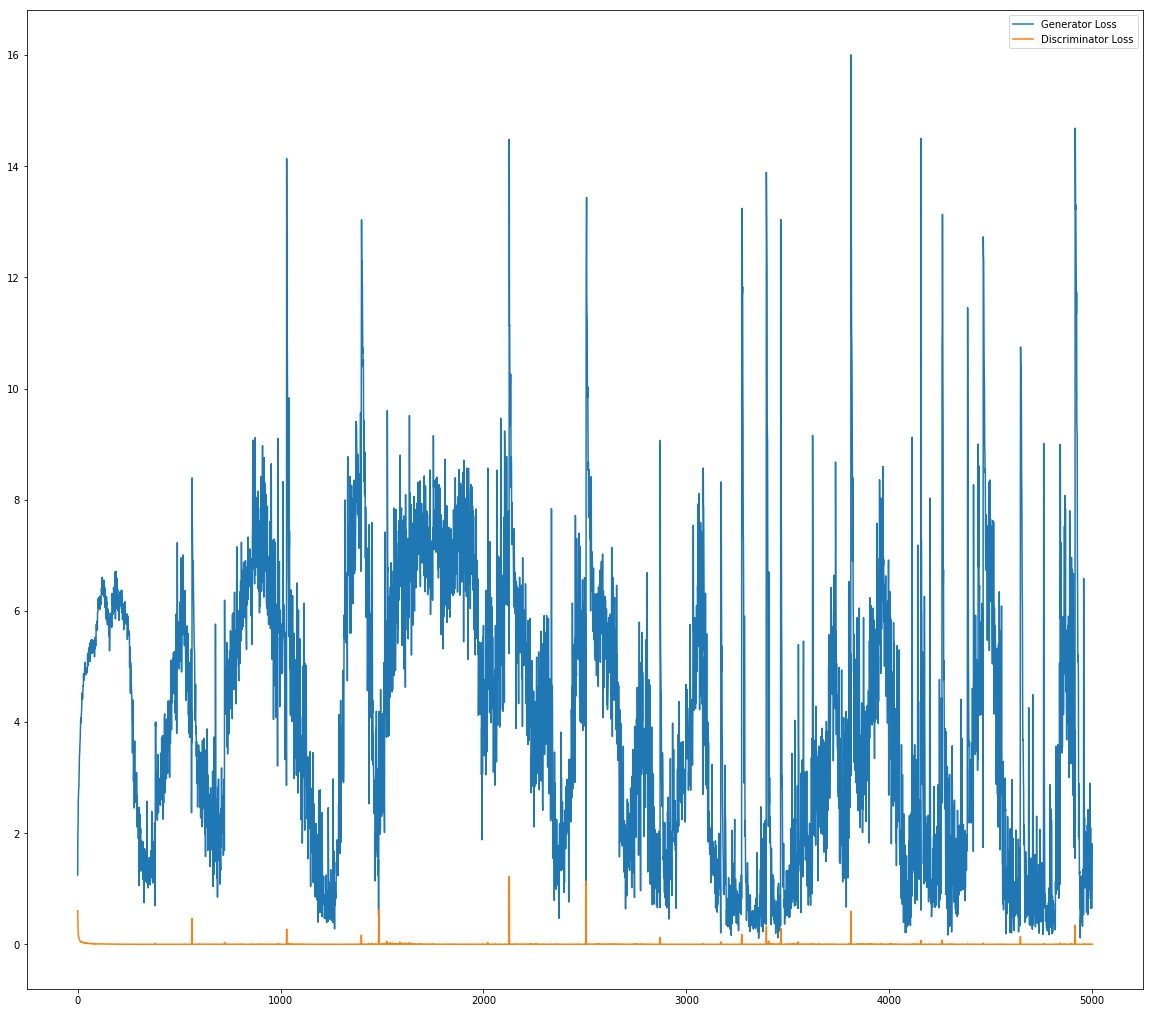

In [6]:
plt.figure(figsize=(20, 18))
plt.plot(train_loss_g, label="Generator Loss");
plt.plot(train_loss_d, label="Discriminator Loss");
plt.legend();

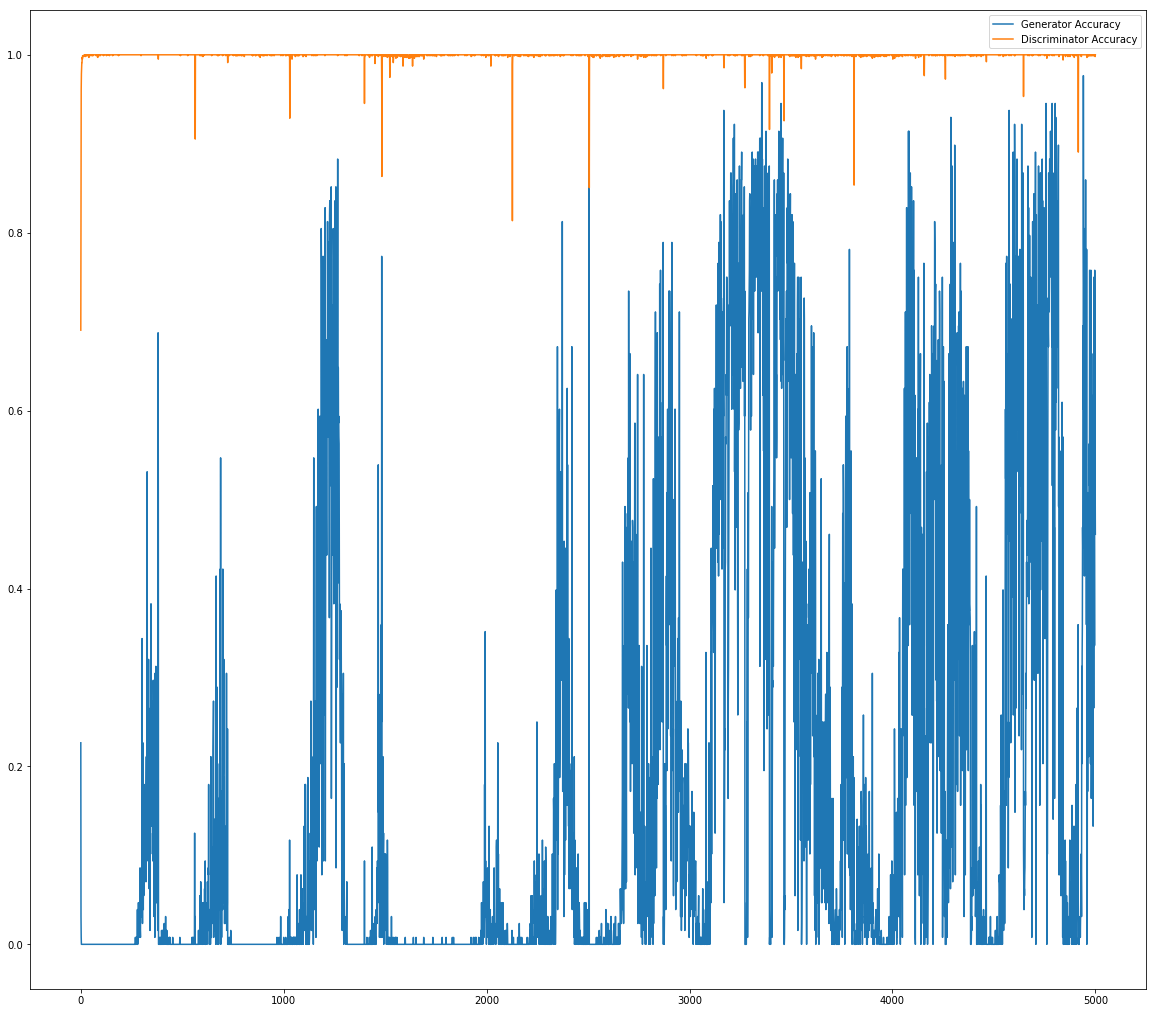

In [7]:
plt.figure(figsize=(20, 18))
plt.plot(train_acc_g, label="Generator Accuracy");
plt.plot(train_acc_d, label="Discriminator Accuracy");
plt.legend();